In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

from luwiji.text_proc import illustration

In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

sw_indo = stopwords.words("indonesian") + list(punctuation)

# Import data

In [3]:
df = pd.read_csv("data/gojek_review_sentiment.csv")
df.head()

review      rate
0  Apa aplikasi yang bagus untuk dengan mudah per...  positive
1  Aplikasi ini banyak membantu saya. Sekarang sa...  positive
2  Mengerikan. Antarmukanya sangat membingungkan....  negative
3  Aplikasi yang cukup mengesankan. Butuh waktu l...  positive
4  Aplikasi ini sebenarnya bagus dan sangat memba...  positive

In [4]:
df.rate.value_counts(normalize=True)

rate
negative    0.595398
positive    0.404602
Name: proportion, dtype: float64

# Encoding

In [5]:
from gensim.models import FastText

In [6]:
w2v = FastText.load("model/fasttext/gojek_review.fasttext").wv

In [14]:
def sent_vec(sentence, w2v_model, stopwords):
    vecs = [w2v_model[word.lower()] for word in word_tokenize(sentence) if word not in stopwords]
    sent_vec = np.mean(vecs, axis=0)
    return sent_vec
def norm_sent_vec(sentence, w2v_model, stopwords):
    vecs = [w2v_model[word.lower()] for word in word_tokenize(sentence) if word not in stopwords]
    norm_vecs = [ vec / np.linalg.norm(vec) for vec in vecs if np.linalg.norm(vec) > 0]
    sent_vec = np.mean(norm_vecs, axis=0)
    return sent_vec

In [15]:
vecs = [norm_sent_vec(sentence, w2v, sw_indo) for sentence in df.review]
vecs = np.array(vecs)
vecs

array([[ 0.01105903, -0.02731838, -0.0067918 , ..., -0.00563093,
         0.0076845 ,  0.03780285],
       [ 0.02049026,  0.03488307, -0.02294993, ...,  0.00790756,
         0.01177741,  0.04141514],
       [-0.05493902, -0.04466862,  0.0056967 , ..., -0.0097248 ,
         0.02640606, -0.01255003],
       ...,
       [ 0.07090642, -0.00700799, -0.03738087, ..., -0.01054735,
         0.00255649, -0.0097506 ],
       [ 0.07584402,  0.04251248, -0.04548198, ..., -0.00127942,
         0.05111073, -0.00543379],
       [-0.03157441, -0.00931202, -0.02988765, ..., -0.01563774,
         0.07376552,  0.06643372]], dtype=float32)

# Dataset Splitting

In [17]:
X = vecs
y = df.rate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1425, 128), (357, 128), (1425,), (357,))

# Training

In [18]:
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [19]:
pipeline = Pipeline([
    # ("prep", TfidfVectorizer(tokenizer=word_tokenize, stop_words=sw_indo)),
    ("algo", SVC(max_iter=500))
])
model = RandomizedSearchCV(pipeline, rsp.svm_params, cv=4, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train);

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 4 folds for each of 50 candidates, totalling 200 fits


/home/zaens/anaconda3/envs/MachineLearning/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/zaens/anaconda3/envs/MachineLearning/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/zaens/anaconda3/envs/MachineLearning/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/zaens/anaconda3/envs/MachineLearning/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/zaens/

{'algo__C': 12.746711578215052, 'algo__gamma': 0.4374364439939081}
0.9122807017543859 0.8694705410253989 0.8851540616246498


/home/zaens/anaconda3/envs/MachineLearning/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


# Evaluation

In [11]:
from jcopml.plot import plot_confusion_matrix

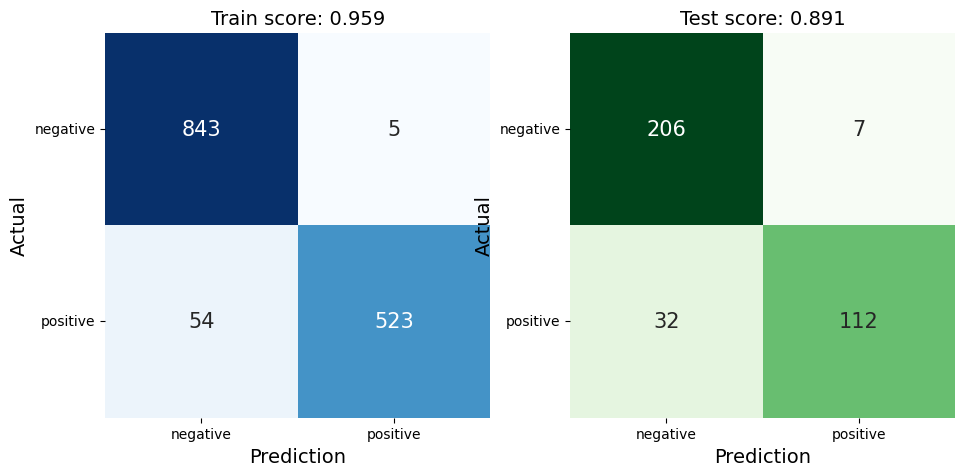

In [12]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

# Sanity Check

In [18]:
text = ["aplikasi kaya anjing enak banget"]
model.predict(text)

array(['negative'], dtype=object)